In [96]:
import sys

import pandas as pd
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]
Pandas version: 1.5.3
Tensorflow version: 2.11.0


<h1>Load data</h1>

In [97]:
train_file = "../data/sas/train.csv"
test_file = "../data/sas/test.csv"

train = pd.read_csv(train_file)
test  = pd.read_csv(test_file)

In [98]:
#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "itemID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(df = train, **header)
#obtain the sparse matrix, users x items
Xtr, u, i = am.gen_affinity_matrix()

In [99]:
Xtst = np.zeros_like(Xtr)
for indx, (user, item, rating, timestamp) in test.iterrows():
    u_index = u[user]
    i_index = i[item]

    Xtst[u_index][i_index] = rating

In [100]:
print('train matrix size', Xtr.shape)
print('test matrix size', Xtst.shape)

train matrix size (5757, 2361)
test matrix size (5757, 2361)


<h1>Train the RBM model</h1>

In [101]:
#First we initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])),
    visible_units=Xtr.shape[1],
    hidden_units=600,
    training_epoch=30,
    minibatch_size=60,
    keep_prob=0.9,
    with_metrics=True
)

2023-02-21 05:14:12.660900: W tensorflow/c/c_api.cc:291] Operation '{name:'key_value_init/LookupTableImportV2' id:6 op device:{requested: '', assigned: ''} def:{{{node key_value_init/LookupTableImportV2}} = LookupTableImportV2[Tin=DT_INT32, Tout=DT_FLOAT, _has_manual_control_dependencies=true](hash_table, Const, Const_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Took 69.11 seconds for training.


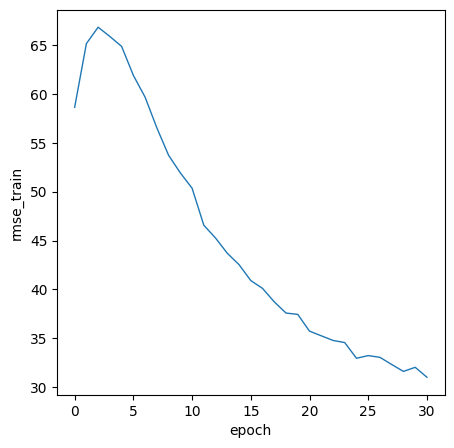

In [102]:
# Model Fit
with Timer() as train_time:
    model.fit(Xtr)

print("Took {:.2f} seconds for training.".format(train_time.interval))

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')

In [103]:
# number of top score elements to be recommended  
K = 10

# Model prediction on the test set Xtst.
with Timer() as prediction_time:
    top_k = model.recommend_k_items(Xtst)

print("Took {:.2f} seconds for prediction.".format(prediction_time.interval))

Took 7.66 seconds for prediction.


In [104]:
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [105]:
top_k_df.head(10)

,userID,itemID,prediction
0,0,925,204.000000
1,0,1710,NaN
2,0,2322,203.999954
3,0,623,NaN
4,0,1178,204.000000
5,0,2249,NaN
6,0,1787,NaN
7,0,1019,204.000000
8,0,2275,NaN
9,0,802,NaN


<h1>Evaluation metrics</h1>

In [106]:
def ranking_metrics(
    data_size,
    data_true,
    data_pred,
    K
):

    eval_map = map_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                    col_rating="rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

    eval_ndcg = ndcg_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                      col_rating="rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

    eval_precision = precision_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= K)

    eval_recall = recall_at_k(data_true, data_pred, col_user="userID", col_item="itemID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

    
    df_result = pd.DataFrame(
        {   "Dataset": data_size,
            "K": K,
            "MAP": eval_map,
            "nDCG@k": eval_ndcg,
            "Precision@k": eval_precision,
            "Recall@k": eval_recall,
        }, 
        index=[0]
    )
    
    return df_result

In [107]:
eval_100k = ranking_metrics(
    data_size="mv 100k",
    data_true=test_df,
    data_pred=top_k_df,
    K=10
)

eval_100k

,Dataset,K,MAP,nDCG@k,Precision@k,Recall@k
0,mv 100k,10,0.006366,0.012641,0.00593,0.016555


In [15]:
if not is_jupyter():
    # Record results with papermill for tests
    import scrapbook as sb
    sb.glue("map", eval_100k['MAP'][0])
    sb.glue("ndcg", eval_100k['nDCG@k'][0])
    sb.glue("precision", eval_100k['Precision@k'][0])
    sb.glue("recall", eval_100k['Recall@k'][0])

<h1>Saving the model and Loading a pre-trained model</h1>

In [ ]:
#model.save(file_path='./models/rbm_model.ckpt')